# NLP pour l’analyse de critiques de films

*David Scanu et Ramata Soraya Dussart*

Dans ce brief, il est question d'analyser le sentiment à travers des critiques en français de spectateurs sur des films.

## Web Scraping des données d’avis de spectacteurs

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [3]:
def scrape_comments(url, max_page):
	"""Function that scrapes comments and associated notes on Allo Ciné."""

	# Headers for request
	HEADERS = ({'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36', 'Accept-Language': 'en-US, en;q=0.5'})

	comments_count = 0

	total_comments_list = []

	for i in range(1, max_page+1):
		
		url_page = url + f"?page={i}"

		# HTTP Request
		webpage = requests.get(url_page, headers=HEADERS)
		# Soup Object containing all data
		soup = BeautifulSoup(webpage.content, "lxml")
		# Comments
		comments = soup.find_all("div", {"class" : "hred review-card cf"})

		# print(f"Page => {i}")
		# print(url_page)

		for comment in comments:

			comment_ls = []
			# Note
			comment_note = comment.find("span", {"class": "stareval-note"}).get_text().replace(',', '.')
			# convert to float
			comment_note_float = float(comment_note)
			# Text
			comment_text = comment.find("div", {"class", "content-txt review-card-content"}).get_text().strip().replace('"', "'").replace("spoiler:", '').replace(" [spoiler]", '')

			comment_ls.append(comment_note_float)
			comment_ls.append(comment_text)

			comments_count += 1
			total_comments_list.append(comment_ls)

	print(f"{comments_count} comments imported in DataFrame.")

	df = pd.DataFrame(total_comments_list, columns=['note', 'comment'])
	return df

#### Inception

In [4]:
url_inception = "https://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/"
df_inception = scrape_comments(url_inception, 479)

7175 comments imported in DataFrame.


In [ ]:
df_inception.shape

(7175, 2)

In [ ]:
df_inception.head()

,note,comment
0,5.0,Après le chef d'oeuvre super-héroïque The Dark...
1,5.0,C’est fou ce qu’on aime détester Christopher N...
2,5.0,CHEF D’ŒUVRE ! Le film est absolument parfait ...
3,5.0,"Un film aussi novateur que complexe, dont la m..."
4,5.0,Christopher Nolan est sûrement l'un des seuls ...


#### Sonic 2

In [ ]:
url_sonic_2 = "https://www.allocine.fr/film/fichefilm-281203/critiques/spectateurs/"
df_sonic_2 = scrape_comments(url_sonic_2, 13)

190 comments imported in DF.


#### Concatenation des deux DataFrame

In [ ]:
print(df_inception.shape)
print(df_sonic_2.shape)

(7175, 2)
(190, 2)


In [ ]:
df = pd.concat([df_inception, df_sonic_2])
df.shape

(7365, 2)

#### Export en fichier .csv

In [ ]:
# Exporting to .csv file
df.to_csv('corpus.csv', sep='|', index=False)
df.shape

(7365, 2)

## Importer le .csv

In [3]:
# Import CSV du corpus
df_from_csv = pd.read_csv('corpus.csv', sep='|')
df_from_csv.shape

(7365, 2)

In [4]:
df_from_csv.head()

,note,comment
0,5.0,Après le chef d'oeuvre super-héroïque The Dark...
1,5.0,C’est fou ce qu’on aime détester Christopher N...
2,5.0,CHEF D’ŒUVRE ! Le film est absolument parfait ...
3,5.0,"Un film aussi novateur que complexe, dont la m..."
4,5.0,Christopher Nolan est sûrement l'un des seuls ...


## Encoder les notes (cible) en 1 et 0

Jusque là, à chaque commentaire est associé une note de 1 à 5 et non une classe binaire. Il nous faut donc convertir nos notes en : *1* pour avis positif et *0* : pour avis négatif. Positif si >= 3.

In [5]:
df_from_csv.loc[(df_from_csv.note < 3), 'note'] = 0 # Avis négatifs
df_from_csv.loc[(df_from_csv.note >= 3), 'note'] = 1 # Avis positifs
print(df_from_csv.note.value_counts())

1.0    6251
0.0    1114
Name: note, dtype: int64


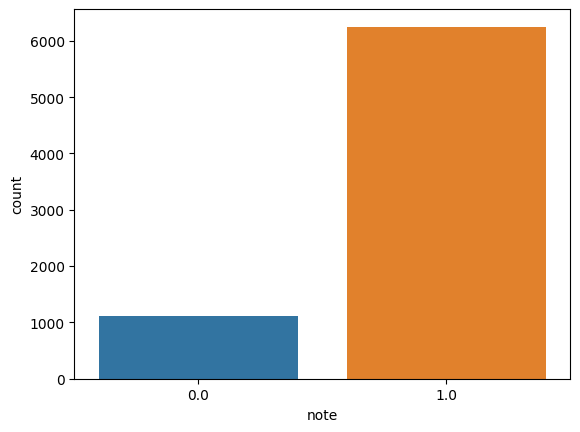

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.countplot(data=df_from_csv, x=df_from_csv['note'])
plt.show()

## Suppression des lignes vides 

In [7]:
# comment < len() == 5

## Suppression avis négatifs

In [8]:
df_from_csv.drop(df_from_csv[(df_from_csv.note == 1) & (df_from_csv.index > 1300)].index, inplace=True)

print(df_from_csv.note.value_counts())


0.0    1114
1.0    1026
Name: note, dtype: int64


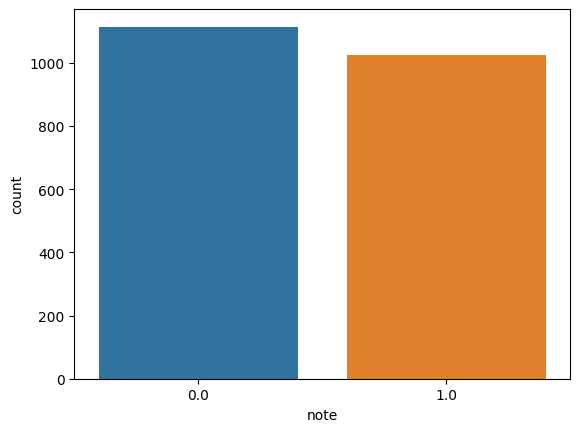

In [9]:
sns.countplot(data=df_from_csv, x=df_from_csv['note'])
plt.show()

## Préparation entrées / sorties

In [10]:
X = df_from_csv['comment']
y = df_from_csv['note']

In [11]:
X.head()

0    Après le chef d'oeuvre super-héroïque The Dark...
1    C’est fou ce qu’on aime détester Christopher N...
2    CHEF D’ŒUVRE ! Le film est absolument parfait ...
3    Un film aussi novateur que complexe, dont la m...
4    Christopher Nolan est sûrement l'un des seuls ...
Name: comment, dtype: object

In [12]:
y.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: note, dtype: float64

## Train Test Split

In [13]:
from sklearn.model_selection import train_test_split

# Split les données, retourne DataFrame ou ndarray
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

print(f"Nombre d'exemples d'entrainement X : {X_train.shape[0]}")
print(f"Nombre d'exemples de test X : {X_test.shape[0]}")
print(' ')
print(f"Nombre d'exemples d'entrainement y : {y_train.shape[0]}")
print(f"Nombre d'exemples de test y : {y_test.shape[0]}")

Nombre d'exemples d'entrainement X : 1712
Nombre d'exemples de test X : 428
 
Nombre d'exemples d'entrainement y : 1712
Nombre d'exemples de test y : 428


## Nettoyage des commentaires

In [14]:
import nltk
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')

def clean_text(text):

    # Standardize text
    text = text.replace(r"http\S+", "")
    text = text.replace(r"http", "")
    text = text.replace(r"@\S+", "")
    text = text.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    text = text.replace(r"@", "at")

    # Lower Casing
    text = text.lower()

    # accents ?

    # Tokenization
    words = nltk.word_tokenize(text) # list

    # Remove punctuation
    new_words = [word for word in words if word.isalnum()]

    # Stop Word Removal
    WordSet = []
    for word in new_words:
        if word not in set(stopwords.words("french")):
            WordSet.append(word)
    
    # Lemmatization
    # lm= WordNetLemmatizer()
    # WordSetLem = []
    # for word in WordSet:
    #     WordSetLem.append(lm.lemmatize(word))

    return ' '.join(WordSet) # return string for CountVectorizer

[nltk_data] Downloading package punkt to /home/david/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/david/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
X_train_clean = X_train.apply(clean_text)
X_test_clean = X_test.apply(clean_text)

In [16]:
X_train_clean.head()

737     film bonne surprise grace scénario plûtot ambi...
122     chef plus nolan magie film tient essentielleme...
440     très original moyen apprécié quelques scènes m...
4588    très belle distribution bien mené effets très ...
1115    tellement génial incroyable jouissif extraordi...
Name: comment, dtype: object

## Word Clouds

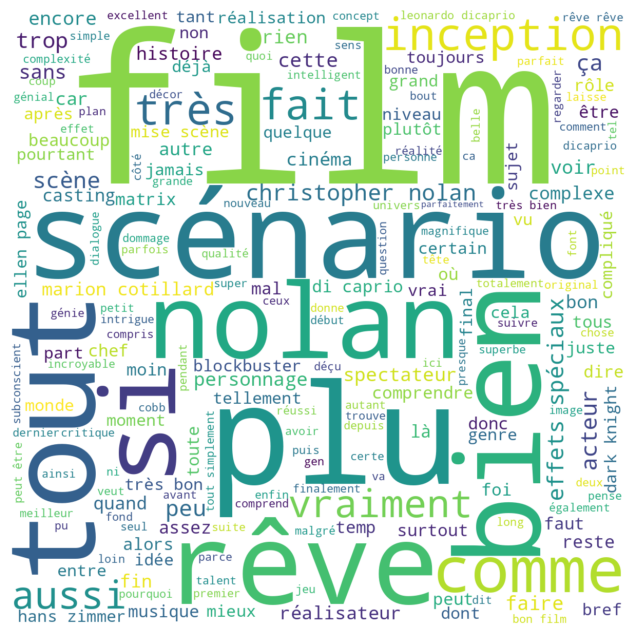

In [17]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

wordcloud = WordCloud(background_color="white", width=1200, height=1200).generate(" ".join(i for i in X_train_clean))
plt.figure( figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Cloud pour les avis négatif

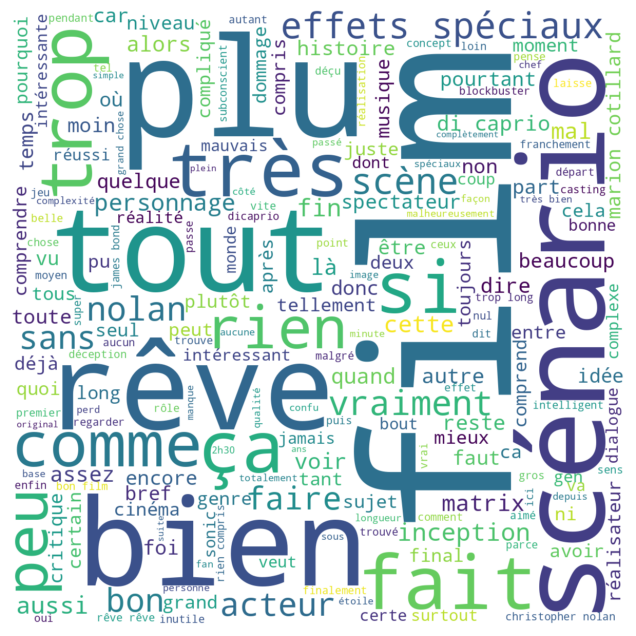

In [18]:
wordcloud = WordCloud(background_color="white", width=1200, height=1200).generate(" ".join(i for i in X_train_clean[y_train == 0]))
plt.figure( figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Word Cloud pour les avis positifs

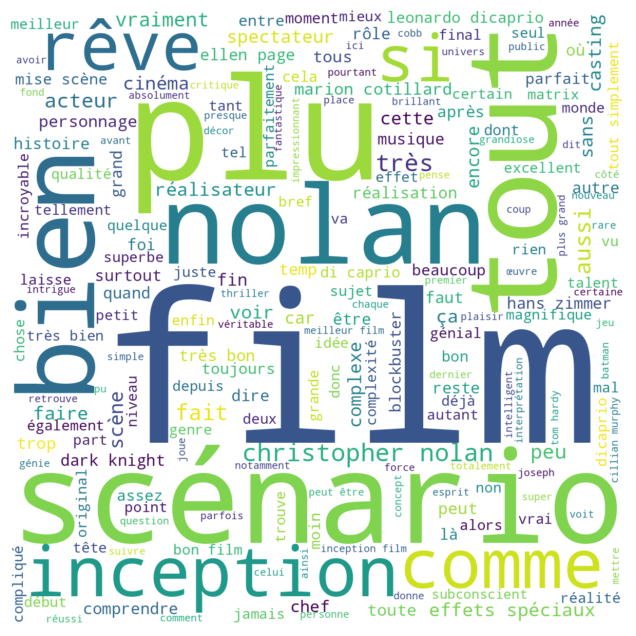

In [19]:
wordcloud = WordCloud(background_color="white", width=1200, height=1200).generate(" ".join(i for i in X_train_clean[y_train == 1]))
plt.figure( figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Vectorisation des textes

#### Count Vectorizer

You should know that **Countvectorizer** has a few important parameters that you should adjust to your problem:

- **max_features**: build a vocabulary that only considers the top n tokens ordered by term frequency across the corpus.
- **min_df**: When building the vocabulary ignore terms that have a token frequency strictly lower than the given threshold
- **max_df**: When building the vocabulary ignore terms that have a token frequency strictly higher than the given threshold.

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# count_vectorizer = CountVectorizer(max_df=10,max_features=10000)
count_vectorizer = CountVectorizer(max_features=10000)
# X_train
X_train_vectors_counts = count_vectorizer.fit_transform(X_train_clean)
# X_test
X_test_vectors_counts = count_vectorizer.transform(X_test_clean)
X_train_vectors_counts.shape

(1712, 10000)

#### TF-IDF

One issue with Countvectorizer is that common words like “the” will appear many times (unless you remove them at the preprocessing stage) and these words are not actually important. One popular alternative is Tfidfvectorizer. It is an acronym for Term frequency-inverse document frequency.

- **Term Frequency**: This summarizes how often a given word appears within a document.
- **Inverse Document Frequency**: This downscales words that appear a lot across documents.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 3))
X_train_tfidf = tfidf.fit_transform(X_train_clean)
X_test_tfidf = tfidf.transform(X_test_clean)
X_train_tfidf.shape

(1712, 170923)

#### Word2Vec

The big issue with the above approaches is that the context of the word is lost when representing it. **Word embeddings** provide a much better representation of the words in NLP by encoding some context information. It provides a mapping from a word to a corresponding n-dimensional vector.

**Word2vec** is composed of two different models:

- **Continuous Bag of Words (CBOW)** model can be thought of as learning word embeddings by training a model to predict a word given its context.
- **Skip-Gram** model is the opposite, learning word embeddings by training a model to predict context given a word.

Some of the important parameters that you can actually change and observe the differences are:

- **size**: this indicates the embedding size of the resulting vector for each word.
- **min_count**: When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold
- **window**: The number of words surrounding the word is considered when building the representation. Also known as the window size.

In [22]:
# import gensim
# from gensim.models import Word2Vec

# model = gensim.models.Word2Vec(corpus, min_count = 1, size = 100, window = 5)

## Sélection et entrainement du modèle

In [23]:
# Grid searching key hyperparametres for logistic regression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_tfidf, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.882202 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.882202 (0.023788) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.882202 (0.023788) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.882202 (0.023788) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.879278 (0.024851) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.879278 (0.024851) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.879278 (0.024851) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.862146 (0.026593) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.862146 (0.026593) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.862729 (0.026258) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.696249 (0.027421) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.696249 (0.027421) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.704037 (0.028009) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.517523 (0.002616) wit

Logistic regression does not really have any critical hyperparameters to tune.

Sometimes, you can see useful differences in performance or convergence with different **solvers (solver)**.

**solver** in [‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’]

**Regularization (penalty)** can sometimes be helpful.

**penalty** in [‘none’, ‘l1’, ‘l2’, ‘elasticnet’]

Note: not all solvers support all regularization terms.

The **C parameter** controls the penality strength, which can also be effective.

**C** in [100, 10, 1.0, 0.1, 0.01]

In [24]:
model_best = grid_result.best_estimator_

## Analyse des résultats

Accuracy of LogisticRegression: 85.51401869158879 %


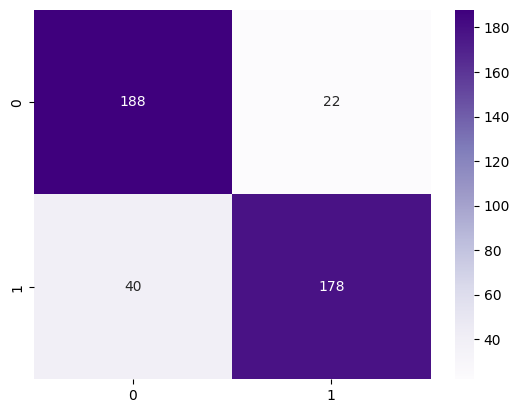

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred_mb = model_best.predict(X_test_tfidf)
acc_mb = accuracy_score(y_pred_mb, y_test)
cm_mb = confusion_matrix(y_pred_mb, y_test)
sns.heatmap(cm_mb, annot=True, cmap='Purples', fmt='g')
print(f"Accuracy of {model_best.__class__.__name__}:", acc_mb*100,"%")

In [28]:
bad_comment = "Ce film ne m'a pas plu du tout. Je l'ai trouvé sans interet. Le scenario est mauvais, les acteurs jouent mal."

# Nettoyer le commentaire
bad_comment_clean = clean_text(bad_comment)
print(bad_comment_clean)

film a plu tout trouvé sans interet scenario mauvais acteurs jouent mal


In [29]:
bad_comment_tfidf = tfidf.transform([bad_comment_clean])
bad_comment_tfidf.shape

(1, 170923)

In [30]:
pred = model_best.predict(bad_comment_tfidf)
pred

array([0.])

## Data Augmentation

### Back Translate

## Export du modèle

Exporter le modèle avec joblib ou Pickle. Il faut exporter :
- Le modèle (clf)
- La fonction de nettoyage
- L'objet de vectorisation

In [31]:
import pickle

dict_export = {}
dict_export['model_best'] = model_best
dict_export['clean_text'] = clean_text
dict_export['tfidf'] = tfidf

pickle_out = open("model.pkl","wb")
pickle.dump(dict_export, pickle_out)
pickle_out.close()